# Basic usage of the cosmoDC2 extragalactic catalog and photoz add-on catalog

### Compute the excess surface density arround clusters using photometrical redshift in cosmoDC2 extragalactic catalog

#### This notebook can be run at NERSC or CC-IN2P3 where the DESC DC2 products are stored. You need to be a DESC member to be able to access those.

In [1]:
import numpy as np
import GCRCatalogs
import matplotlib.pyplot as plt
import scipy.integrate

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join
import GCRCatalogs
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
    
import healpy

# 1. Prepare a dark matter halo from cosmoDC2

In [3]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In order to speed up the extraction of dark matter halo/galaxy qualtities, we decide to find cluster within a specified healpix pixel. For that we recover the healpix pixel list of the cosmoDC2 extragalactic catalog and select a given healpix pixel. We then extract the halo catalof in this sky area with given property cut

In [4]:
healpix_pixels = extragalactic_cat.get_catalog_info()['healpix_pixels']

In [5]:
healpix_selected = healpix_pixels[10]
print('The selected healpix pixel is ' + str(healpix_selected))

The selected healpix pixel is 10072


In [6]:
# get list of massive halos in a given redshift and mass range
mmin = 1.e14 # Msun
zmin = 0.
zmax = 1
massive_halos = extragalactic_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id'],
                                                 filters=[f'halo_mass > {mmin}','is_central==True',
                                                          f'redshift>{zmin}', f'redshift<{zmax}'], native_filters=['healpix_pixel == ' + str(healpix_selected)])
N_cl = len(massive_halos['halo_mass'])
print(f'There are {N_cl} clusters in this mass and redshift range')

There are 47 clusters in this mass and redshift range


In [7]:
select = massive_halos['halo_mass'] == np.max(massive_halos['halo_mass'])
ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl =massive_halos['halo_mass'][select][0]
id_cl = massive_halos['halo_id'][select][0]

In [8]:
print (f'The most massive cluster is halo {id_cl} in ra = {ra_cl:.2f} deg, dec = {dec_cl:.2f} deg, z = {z_cl:.2f}, with mass = {mass_cl:.2e} Msun')

The most massive cluster is halo 93100157401 in ra = 67.48 deg, dec = -40.93 deg, z = 0.22, with mass = 7.82e+14 Msun


# 2. Extract background galaxy catalog with location and shape properties

### Apply coordinates, redshift and magnitude cuts to select backgroud galaxies around the cluster

- Box of 0.6 deg around the cluster center
- Galaxies with z > z_cluster + 0.1
- Galaxies with mag_i < 25
- Here, we’re directly gathering the shear components $\gamma_1, \gamma_2$, the convergence $\kappa$ and the intrinsic ellipticities of galaxy.


In [9]:
ra_min, ra_max = ra_cl - 0.3, ra_cl + 0.3
dec_min, dec_max = dec_cl - 0.3, dec_cl + 0.3
z_min = z_cl + 0.1
mag_i_max = 25

To speed up the extraction, we load the catalog in the contiguous healpix pixels arround the cluster position corresponding to a window O.6 deg

In [10]:
n_points = 300
ra_random, dec_random = np.random.random(n_points)*(ra_max - ra_min) + ra_min, np.random.random(n_points)*(dec_max - dec_min) + dec_min
contiguous_healpix_pixels = np.unique(healpy.ang2pix(32, ra_random, dec_random, nest=False, lonlat=True))
print('The contiguous healpix pixels arround the cluster position are '+ str(contiguous_healpix_pixels))

The contiguous healpix pixels arround the cluster position are [10072]


In [12]:
%%time
coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]
z_filters = ['redshift >= {}'.format(z_min)]
mag_filters = ['mag_i < {}'.format(mag_i_max)]
gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 
                                            'ra', 'dec',
                                            'shear_1', 'shear_2', 
                                            'ellipticity_1_true', 'ellipticity_2_true',
                                            'redshift', 'convergence'],
                                            filters=(coord_filters + z_filters + mag_filters), 
                                            native_filters=['healpix_pixel == ' + str(healpix_selected)])
print(str(len(gal_cat['galaxy_id'])) +' saved galaxies')

33313 saved galaxies
CPU times: user 30.2 s, sys: 12.5 s, total: 42.7 s
Wall time: 42.7 s


We compute the obseved galaxy ellipticities using shear, convergence and intrinsic ellipticities

In [13]:
gal_cat['e1'] = clmm.utils.compute_lensed_ellipticity(gal_cat['ellipticity_1_true'], 
                                                      gal_cat['ellipticity_2_true'], 
                                                      gal_cat['shear_1'], gal_cat['shear_2'], 
                                                      gal_cat['convergence'])[0]
gal_cat['e2'] = clmm.utils.compute_lensed_ellipticity(gal_cat['ellipticity_1_true'], 
                                                      gal_cat['ellipticity_2_true'], 
                                                      gal_cat['shear_1'], 
                                                      gal_cat['shear_2'], 
                                                      gal_cat['convergence'])[1]

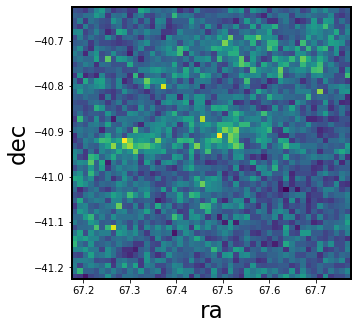

In [14]:
plt.figure(figsize = (5,5))
plt.rcParams['axes.linewidth'] = 2
plt.hist2d(gal_cat['ra'], gal_cat['dec'], cmin = 1, bins = [50, 50])
plt.xlabel('ra', fontsize = 23)
plt.ylabel('dec', fontsize = 23)
plt.show()

In [15]:
gal_cat['z'] = gal_cat['redshift']

In [16]:
gal_cat = Table(gal_cat)

# Extract photometrical related informations for background galaxies

In [17]:
%%time
cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_with_photozs_v1')

CPU times: user 2.33 s, sys: 1.29 s, total: 3.63 s
Wall time: 4.2 s


In [18]:
%%time
photoz_cat = cat.get_quantities(['photoz_pdf','photoz_mean','photoz_odds','redshift', 'galaxy_id'],
                            native_filters=['healpix_pixel=='+str(contiguous_healpix_pixels[0])])

CPU times: user 26.6 s, sys: 19.6 s, total: 46.2 s
Wall time: 46 s


In [19]:
tab_astropy = Table()

In [20]:
tab_astropy['galaxy_id'] = photoz_cat['galaxy_id']

tab_astropy['photoz_pdf'] =  photoz_cat['photoz_pdf']

tab_astropy['photoz_mean'] =  photoz_cat['photoz_mean']

tab_astropy['photoz_odds'] = photoz_cat['photoz_odds']

mask = np.isin(tab_astropy['galaxy_id'],np.array(gal_cat['galaxy_id']))

tab_cut = tab_astropy[mask]

### join bakground galaxy catalog and photometrical information catalog

In [21]:
cat_complete = join(tab_cut, gal_cat, keys = 'galaxy_id')

# 3. Compute weights for the excess surface density estimator

- The excess surface density estimator is defined by $\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{l,s = 1} w_{l,s}}
     \sum\limits_{l,s= 1}w_{l,s}\langle\Sigma_{{\rm crit}}(z_s, z_l)^{-1}\rangle^{-1}\gamma_+^{l,s}$
     
- where the critical surface mass density expresses as $\Sigma_{{\rm crit}}(z_s, z_l) = \frac{c^2}{4 \pi G} \frac{D_A(z_s)}{D_A(z_l) D_A(z_s, z_l)}$,

- and the average is defined as $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle = \int_{z_l + 0.1}^{+\infty} d z_s\ p(z_s)\Sigma_{\rm crit}(z_s,z_l)^{-1}$, where $p$ is the photmometrical probaility density function of the background galaxy
- In the case where there is no error on the shape measurement, the weight $w_{ls}$ writes $w_{ls} = \langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle^{2}$,

- In the case of true redshift, the pdf reduces to a Dirac function returning $\langle\Sigma_{\rm crit}(z_l,z_s)^{-1}\rangle = \Sigma_{\rm crit}(z_l,z_s)^{-1} $ and $w_{ls} = \Sigma_{\rm crit}(z_s,z_l)^{-2}$,


### We compute the weight $w_{ls}$ considering:
- true backgroud galaxy redshift $w_{ls}^{\rm true}$
- photometrical pdf $w_{ls}^{\rm pdf}$
- mean redshift (integration over the pdf) $w_{ls}^{\rm mean}$
- mode redshift $w_{ls}^{\rm mode}$

In [22]:
z_bins = cat.photoz_pdf_bin_centers

In [23]:
cosmo = clmm.Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [24]:
sigma_crit_1 = 1/cosmo.eval_sigma_crit(z_min, z_bins)

In [25]:
unormed_integral = scipy.integrate.simps(cat_complete['photoz_pdf'] * sigma_crit_1, x=z_bins, axis = 1)
norm = scipy.integrate.simps(cat_complete['photoz_pdf'], x=z_bins, axis = 1)

In [26]:
w_ls_photozs = (unormed_integral/norm)**2
w_ls_true = (1/cosmo.eval_sigma_crit(z_min, cat_complete['redshift']))**2
w_ls_mean = (1/cosmo.eval_sigma_crit(z_min, cat_complete['photoz_mean']))**2

In [27]:
w_ls_random = []
for pdf in cat_complete['photoz_pdf']:
    w_ls_random.append(np.random.choice(1./cosmo.eval_sigma_crit(z_min, z_bins), p = pdf/np.sum(pdf))**2)
w_ls_random = np.array(w_ls_random)

### we plot the probability $p_{l,s} = \frac{w_{l,s}}{\sum_s w_{l,s}}$

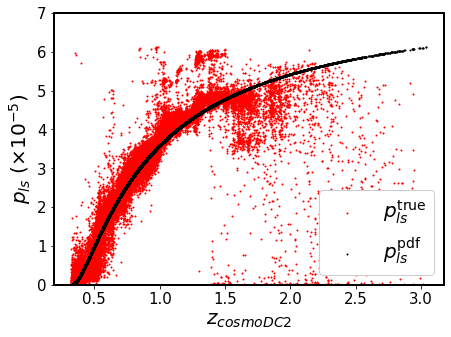

In [28]:
plt.figure(figsize = (7,5))
plt.scatter(cat_complete['redshift'], 1e5*w_ls_photozs/np.sum(w_ls_photozs), s = 1, c = 'r', label = r'$p_{ls}^{\rm true}$')
plt.scatter(cat_complete['redshift'], 1e5*w_ls_true/np.sum(w_ls_true), s = 1, c = 'k', label = r'$p_{ls}^{\rm pdf}$')
plt.ylabel(r'$p_{ls}\ (\times 10^{-5})$', fontsize = 20)
plt.xlabel(r'$z_{cosmoDC2}$', fontsize = 20)
plt.tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)
plt.legend(fontsize = 20, loc = 'lower right', frameon = True, framealpha = 1)
plt.ylim(0,7)
plt.show()

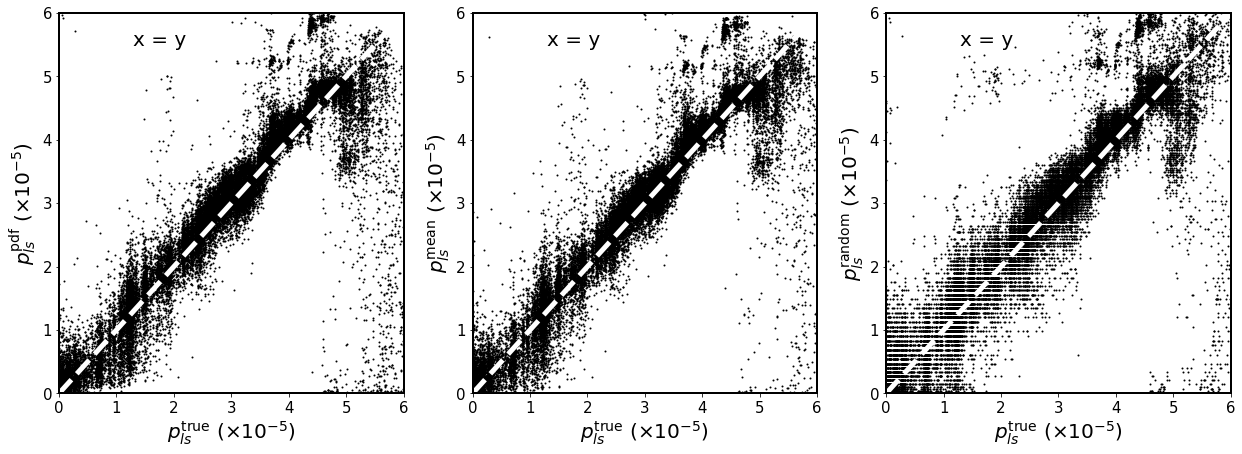

In [29]:
w_ls_with_photozs = [w_ls_photozs, w_ls_mean, w_ls_random]
label = [r'$p_{ls}^{\rm pdf}\ (\times 10^{-5})$', 
         r'$p_{ls}^{\rm mean}\ (\times 10^{-5})$', 
         r'$p_{ls}^{\rm random}\ (\times 10^{-5})$']

x = np.linspace(0, 7, 100)
fig, axs = plt.subplots(1, 3, figsize = (21,7))
for i in range(3):
    
    axs[i].scatter(w_ls_true/np.sum(w_ls_true)*1e5, 1e5*w_ls_with_photozs[i]/np.sum(w_ls_with_photozs[i]), s = 1, c='k')
    axs[i].plot(x,x, '--w', linewidth = 5, label = 'x = y', c = 'w')
    axs[i].set_xlabel(r'$p_{ls}^{\rm true}\ (\times 10^{-5})$', fontsize = 20)
    axs[i].set_ylabel(label[i], fontsize = 20)
    axs[i].tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)
    axs[i].legend(fontsize = 20, loc = 'upper left', frameon = False)
    axs[i].set_ylim(0,6)
    axs[i].set_xlim(0,6)

# Make shear profile

In [30]:
data = clmm.GCData(cat_complete)
cl = clmm.GalaxyCluster('DM_halo', ra_cl, dec_cl, z_cl, data)


In [31]:
cl.compute_tangential_and_cross_components(
                                    shape_component1='e1', shape_component2='e2', 
                                    tan_component='shear_t', cross_component='shear_x',
                                    geometry="flat")
print( )

In [32]:
cl.galcat['r'] = cosmo.eval_da(cl.z)*cl.galcat['theta']

In [33]:
cl.galcat['w_ls_true'] = np.array(w_ls_true)
cl.galcat['w_ls_photoz_pdf'] = np.array(w_ls_photozs)
cl.galcat['w_ls_mean'] = np.array(w_ls_mean)
cl.galcat['w_ls_random'] = np.array(w_ls_random)

In [34]:
bin_edges = clmm.make_bins(0.1,  5, nbins=10, method='evenlog10width')

In [35]:
radial_bin = [[bin_edges[i], bin_edges[i + 1]] for i in range(len(bin_edges)-1)]

In [36]:
names = ['r', 'DS', 'DS_err']

profile_true = Table(names=names)
profile_pdf = Table(names=names)
profile_mean = Table(names=names)
profile_random = Table(names=names)

for i, r_bin in enumerate(radial_bin):
    mask = (cl.galcat['r'] > r_bin[0])*(cl.galcat['r'] < r_bin[1])*\
    (cl.galcat['w_ls_photoz_pdf'] > 0)*(cl.galcat['w_ls_mean'] != 0)*(cl.galcat['w_ls_random'] != 0)
    
    data_cut = cl.galcat[mask]
    r_mean = np.mean(data_cut['r'])
    
    ds_true = np.average(data_cut['shear_t']*data_cut['w_ls_true']**(-0.5), 
                         weights = data_cut['w_ls_true'])
    ds_true_rms = np.sqrt(np.average((data_cut['shear_t']*data_cut['w_ls_true']**(-0.5) - ds_true)**2, 
                                     weights = data_cut['w_ls_true']))/np.sqrt(len(data_cut))
    
    ds_photoz_pdf = np.average(data_cut['shear_t']*data_cut['w_ls_photoz_pdf']**(-0.5), 
                               weights = data_cut['w_ls_photoz_pdf'])
    
    ds_photoz_pdf_rms = np.sqrt(np.average((data_cut['shear_t']*data_cut['w_ls_photoz_pdf']**(-0.5) - ds_photoz_pdf)**2, 
                                           weights = data_cut['w_ls_photoz_pdf']))/np.sqrt(len(data_cut))
    
    ds_mean = np.average(data_cut['shear_t']*data_cut['w_ls_mean']**(-0.5), 
                         weights = data_cut['w_ls_mean'])
    
    ds_mean_rms = np.sqrt(np.average((data_cut['shear_t']*data_cut['w_ls_mean']**(-0.5) - ds_mean)**2, 
                                     weights = data_cut['w_ls_mean']))/np.sqrt(len(data_cut))
    
    ds_random = np.average(data_cut['shear_t']*data_cut['w_ls_random']**(-0.5), 
                         weights = data_cut['w_ls_random'])
    
    ds_random_rms = np.sqrt(np.average((data_cut['shear_t']*data_cut['w_ls_random']**(-0.5) - ds_random)**2, 
                                     weights = data_cut['w_ls_random']))/np.sqrt(len(data_cut))
    
    profile_true.add_row([r_mean, ds_true, ds_true_rms])
    profile_pdf.add_row([r_mean, ds_photoz_pdf,  ds_photoz_pdf_rms])
    profile_mean.add_row([r_mean, ds_mean,  ds_mean_rms])
    profile_random.add_row([r_mean, ds_random,  ds_random_rms])

# plot Excess surface density profile

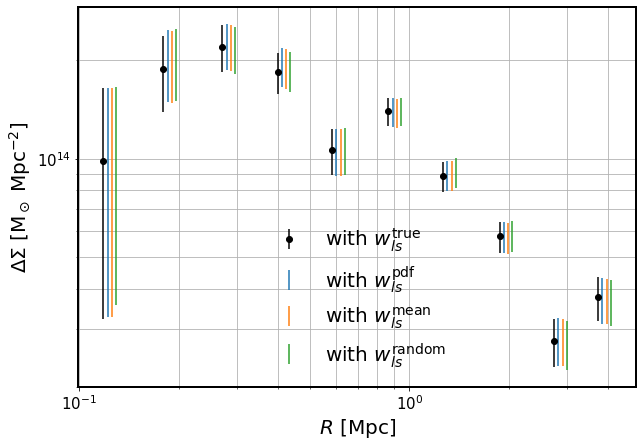

In [37]:
ylabelup = r'$\Delta\Sigma$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$'
ylabeldown = r'$\Delta\Sigma_\times$ ' +'$[$' + r'$\times 10^{13}$ ' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$'
xlabel = r'$R\ [$' + r'${\rm Mpc}$' + r'$]$'
plt.figure(figsize = (10,7))
plt.grid(True, which="both", ls="-")
plt.rcParams['axes.linewidth'] = 2
plt.tick_params(axis='both', which = 'both', labelsize= 15)
deltalogr = 0.03
dr = deltalogr*profile_true['r']
plt.errorbar(profile_true['r']-1*dr, profile_true['DS'], profile_true['DS_err'], c='k', fmt = ' ', marker = 'o', label = r'with $w_{ls}^{\rm true}$')
plt.errorbar(profile_true['r']+0*dr, profile_pdf['DS'], profile_pdf['DS_err'], fmt = ' ',label = r'with $w_{ls}^{\rm pdf}$')
plt.errorbar(profile_true['r']+1*dr, profile_mean['DS'], profile_mean['DS_err'], fmt = ' ', label = r'with $w_{ls}^{\rm mean}$')
plt.errorbar(profile_true['r']+2*dr, profile_random['DS'], profile_random['DS_err'], fmt = ' ', label = r'with $w_{ls}^{\rm random}$')
plt.loglog()
plt.xlabel(xlabel, fontsize = 20)
plt.ylabel(ylabelup, fontsize = 20)
plt.legend(frameon = False, fontsize = 20, loc = 'lower center')
plt.show()